## init

In [38]:
# import sys 
# sys.path.append('pyfiles/')

from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid
)

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
import math
from collections import defaultdict
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance
from scipy.stats import qmc
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import csv
import string

# for polygon grid
from matplotlib.path import Path as mplPath

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies between functions.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## this is the new, streamlined thing

In [37]:
our_complex = inp.read_obj("input/blob.obj")
key_point1 = (0.4, 0.6)
key_point2 = (0.6, 0.6)
o = cplx.ordering.by_dist_to(our_complex, key_point1)
o2 = cplx.ordering.by_dist_to(our_complex, key_point2)
matrix = mat.bdmatrix.from_ordering(o)
# with ourplot.PandasMatrix(matrix, o) as p:
#     matrix.reduce(every_step=p.every_step)

bettis = defaultdict(int)
def after_column_reduced(mat, j):
    if mat.get(j, set()):
        death = o.simplex(j)
        birth = o.simplex(max(mat.get(j, set())))
        bettis[birth.dim()] -= 1
        print(f'col {j}:')
        print(f'  birth={birth}')
        print(f'  death={death}')
    else:
        s = o.simplex(j)
        bettis[s.dim()] += 1
        print(f'col {j}: reduced to zero: {s}')

ourplot.plot_orders_with_bubbles(o, o2)

KeyboardInterrupt: 

In [110]:
our_complex = inp.read_obj("input/blob.obj")
key_point1 = (0.75, 0.40)
key_point2 = (0.75, 0.25)
o = cplx.ordering.by_dist_to(our_complex, key_point1)
o2 = cplx.ordering.by_dist_to(our_complex, key_point2)
matrix = mat.bdmatrix.from_ordering(o)

n = our_complex.nedges() + our_complex.nverts() + 1
V = np.eye(n, dtype=int)
def record_column_adds(sparsemat, indices, old_column):
  V[:, indices[0]] = (V[:, indices[0]] + V[:, indices[1]]) % 2

matrix.reduce(every_step=record_column_adds);
assert (((matrix.initmatrix @ V) % 2) == matrix.reduced).all(), 'Something is wrong with the column reduction'

U = np.absolute(np.linalg.inv(V).astype(int)) % 2

assert (((U @ V) % 2) == np.eye(n, dtype=int)).all(), 'U@V didn\'t give identity matrix'
assert (((V @ U) % 2) == np.eye(n, dtype=int)).all(), 'V@U didn\'t give identity matrix'



In [111]:
our_complex = inp.read_obj("input/triangle.obj")
key_point1 = (0.75, 0.40)
o = cplx.ordering.by_dist_to(our_complex, key_point1)
matrix = mat.bdmatrix.from_ordering(o)

knowledge = mat.reduction_knowledge(matrix, o)
knowledge.run()

# R = DV
D = matrix.initmatrix
R = matrix.reduced

V = np.eye(D.shape[0], dtype=int);
for (target, other) in knowledge.adds:
  V[:, target] = (V[:, target] + V[:, other]) % 2
assert (((D @ V) % 2) == R).all(), 'Something is wrong with the column reduction'

# RU = D
U = vin.matrix_inverse(V)

assert (((R @ U) % 2) == D).all(), 'Something is wrong with the column reduction'


for i in range(0, R.shape[0] - 1):
  P = vin.permutation_matrix(R.shape[0], i, i + 1)
  PDP = (P.T @ D @ P) % 2
  (RR, UU, faustian_swap) = vin.perform_one_swap(i, knowledge, R, U)
  RRUU = (RR @ UU) % 2
  assert (RRUU == PDP).all(), 'Something is wrong with the column reduction'


y = -1.0
pt_i = 0
reduction start
reduction end
inverse start
inverse end
swapped_indices = #8
pt_i = 1
swapped_indices = #12
pt_i = 2
swapped_indices = #30
pt_i = 3
swapped_indices = #52
pt_i = 4
swapped_indices = #71
pt_i = 5
swapped_indices = #74
pt_i = 6
swapped_indices = #52
pt_i = 7
swapped_indices = #30
pt_i = 8
swapped_indices = #11
pt_i = 9
swapped_indices = #8
y = -0.7777777777777778
pt_i = 0
reduction start
reduction end
inverse start
inverse end
swapped_indices = #8
pt_i = 1
swapped_indices = #16
pt_i = 2
swapped_indices = #26
pt_i = 3
swapped_indices = #42
pt_i = 4
swapped_indices = #85
pt_i = 5
swapped_indices = #88
pt_i = 6
swapped_indices = #42
pt_i = 7
swapped_indices = #26
pt_i = 8
swapped_indices = #15
pt_i = 9
swapped_indices = #8
y = -0.5555555555555556
pt_i = 0
reduction start
reduction end
inverse start
inverse end
swapped_indices = #8
pt_i = 1
swapped_indices = #14
pt_i = 2
swapped_indices = #28
pt_i = 3
swapped_indices = #36
pt_i = 4
swapped_indices = #96
pt_i 

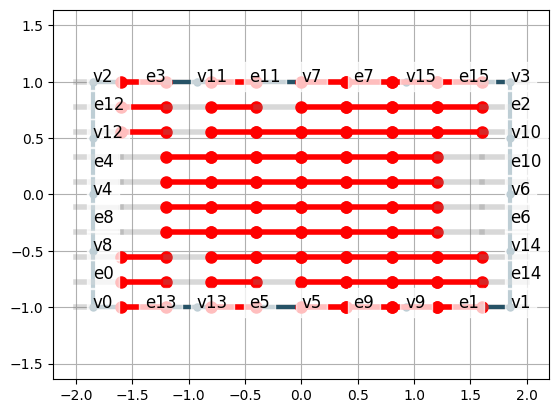

In [12]:

our_complex = inp.read_obj("input/rectangle-4.obj")
ourplot.plot_complex(our_complex, label_edges=True, label_verts=True)
key_point1 = (0.0, 0.6)

N = 10
for y in np.linspace(-1.0, 1, N):
  print(f'y = {y}')
  def get_pairs_of_points(i, n):
    return (
      [ -2 + 4 / n *  i, y],
      [-2 + 4 / n * (i+1), y]
    )

  for pt_i in range(0, N):
    print(f'pt_i = {pt_i}')
    (key_point1, key_point2) = get_pairs_of_points(pt_i, N)
    if pt_i == 0:
      o1 = cplx.ordering.by_dist_to(our_complex, key_point1)

      matrix = mat.bdmatrix.from_ordering(o1)
      knowledge = mat.reduction_knowledge(matrix, o1)
      print(f'reduction start')
      knowledge.run()
      print(f'reduction end')

      # R = DV
      D = matrix.initmatrix
      R = matrix.reduced

      V = np.eye(D.shape[0], dtype=int);
      for (target, other) in knowledge.adds:
        V[:, target] = (V[:, target] + V[:, other]) % 2
      assert (((D @ V) % 2) == R).all(), 'Something is wrong with the column reduction'

      # RU = D
      print(f'inverse start')
      U = vin.matrix_inverse(V)
      print(f'inverse end')
      assert (((R @ U) % 2) == D).all(), 'Something is wrong with the column reduction'

    o1 = cplx.ordering.by_dist_to(our_complex, key_point1)
    o2 = cplx.ordering.by_dist_to(our_complex, key_point2)
    (swapped_simplices, _, swapped_indices) = o1.compute_transpositions(o2)

    found_faustian = False
    print(f'swapped_indices = #{len(swapped_indices)}')
    for (swap_i, i) in enumerate(swapped_indices):
      P = vin.permutation_matrix(R.shape[0], i, i + 1)
      PDP = (P.T @ D @ P) % 2
      (RR, UU, faustian_swap) = vin.perform_one_swap(i, knowledge, R, U)

      if faustian_swap:
        found_faustian = True

      RRUU = (RR @ UU) % 2
      # assert (RRUU == PDP).all(), 'Something is wrong with the column reduction'
      R = RR
      U = UU
      D = PDP

    # f = 0.5
    # pt = (1 - f) * np.array(key_point1) + f * np.array(key_point2)
    if found_faustian:
      plt.plot([key_point1[0], key_point2[0]], [key_point1[1], key_point2[1]], 'o-', markersize=8, linewidth=4, color='red' )
    else:
      plt.plot([key_point1[0], key_point2[0]], [key_point1[1], key_point2[1]], '-', alpha=0.3, linewidth=4, color='gray' )



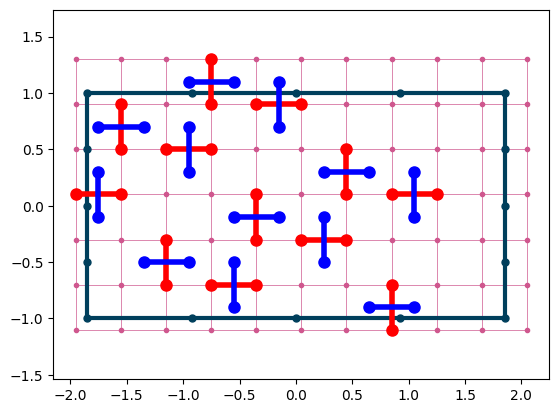

In [54]:
# Load input file
our_complex = inp.read_obj("input/rectangle-4.obj")
key_point1 = (0.0, 0.6)

gridd = grid.Grid.from_complex(our_complex, 0.4, buffer=0.1)

# # Make grid
# points, edge_indices = grid.from_complex(
#   our_complex, 
#   0.4,
#   buffer=0.1
# )

# def rotate90(v: np.ndarray):
#   return np.array([-v[1], v[0]])

#   ax.plot([p[0], q[0]], [p[1], q[1]], 'o-', markersize=8, linewidth=4, color='red' )
#   ax.plot([up[0], down[0]], [up[1], down[1]], 'o-', markersize=8, linewidth=4, color='blue' )


# def dual_grid_edge(i, ):
#   pass


def debug_plot(ax, i):
  if gridd.is_boundary_edge(i):
    return
  
  p = gridd.points[gridd.edge_indices[i, 0]]
  q = gridd.points[gridd.edge_indices[i, 1]]
  ax.plot([p[0], q[0]], [p[1], q[1]], 'o-', markersize=8, linewidth=4, color='red' )

  a, b = gridd.dual_edge(i)
  ax.plot([a[0], b[0]], [a[1], b[1]], 'o-', markersize=8, linewidth=4, color='blue' )
  


# Plot things
fig,ax = plt.subplots()
ax.set_aspect('equal')
ourplot.plot_grid(ax, gridd)
ourplot.plot_complex(our_complex, label_verts=False, ax=ax)

for i in range(0,100, 7):
  debug_plot(ax, i)

# get_some_kinds_of_points(points, edge_indices[18, :], ax)
# get_some_kinds_of_points(points, edge_indices[19, :], ax)